In [233]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import astra
import pywt

from tqdm import tqdm

%matplotlib inline

# Part B

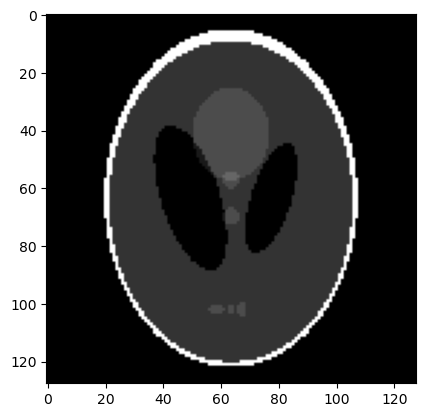

In [234]:
# Load data
SLphantom = np.load('../data/SLphan.npy')

f_true = SLphantom
plt.imshow(f_true, cmap='gray')

In [235]:
def Randon_Transform(f, angles, det_count=128, detector_spacing=1.):
    # Create volume geometries
    v, h = f.shape
    vol_geom = astra.create_vol_geom(v, h)

    # Create projector geometries

    # det_count = int(v / detector_spacing)count, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, det_count, angles)

    # Create projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Radon transform (generate sinogram)
    sinogram_id, sinogram = astra.create_sino(f, projector_id)

    return vol_geom, proj_geom, projector_id, sinogram_id, sinogram

def Radon_Back_Proj(vol_geom, sinogram_id, projector_id, ptype='BP'):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(ptype)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

#### Create sinogram with missing measurements

In [236]:
def create_undersampled(obj, n_projs, proj_space):
    # n_projs: int, proj_space: int
    # n_projs % proj_space == 0
    angles = np.linspace(0, np.pi, 180, endpoint=False)
    vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(obj, angles, n_projs // proj_space, proj_space)
    g_us = np.zeros((180, n_projs))
    mask = np.zeros((180, n_projs))
    g_us[:, 0:n_projs:proj_space] = g
    mask[:, 0:n_projs:proj_space] = np.ones_like(g)
    rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
    return g_us, mask, rec

def create_limited_angles(obj, degree, n_projs):
    # degree: int [0, 90], n_projs: int
    # n_projs % proj_space == 0
    angles = np.hstack((
        np.linspace(0, np.pi * degree / 180., degree, endpoint=False),
        np.linspace(np.pi * (1. - degree / 180.), np.pi, degree, endpoint=False)
    ))
    vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(obj, angles, n_projs, 1)
    g_la = np.zeros((180, n_projs))
    mask = np.zeros((180, n_projs))
    g_la[:degree] = g[:degree]
    g_la[180-degree:] = g[degree:]
    mask[:degree] = np.ones_like(g[:degree])
    mask[180-degree:] = np.ones_like(g[degree:])
    rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
    return g_la, mask, rec

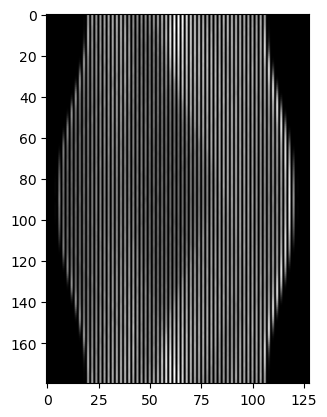

In [367]:
g_us, mask_us, rec_us = create_undersampled(f_true, 128, 2)

angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g_us_true = Randon_Transform(f_true, angles, 128, 1)

plt.imshow(g_us, cmap='gray')

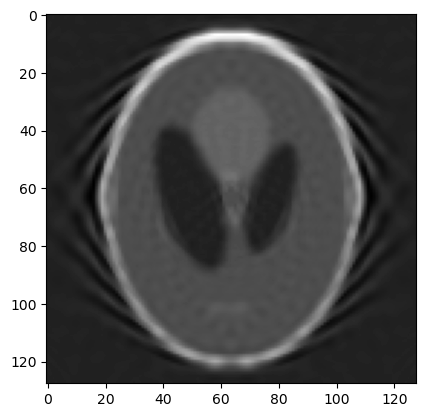

In [366]:
plt.imshow(rec_us, cmap='gray')

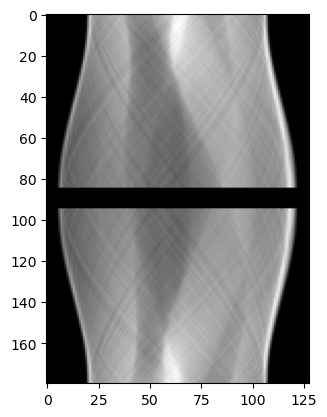

In [381]:
g_la, mask_la, rec_la = create_limited_angles(f_true, 85, 128)
plt.imshow(g_la, cmap='gray')

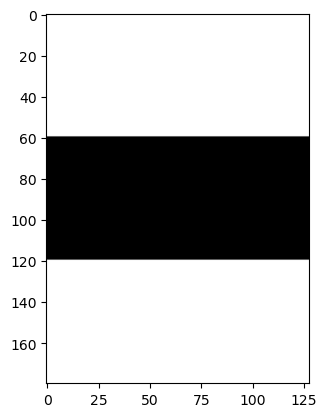

In [240]:
plt.imshow(mask_la, cmap='gray')

#### Inpainting based on an istotropic Laplacian

In [272]:
def construct_masking_operator(mask):
    mf = mask.flatten()
    col_idx = np.where(mf==1)[0]
    row_idx = np.arange(col_idx.shape[0])
    data = np.ones_like(col_idx)
    return scipy.sparse.csr_matrix((data, (row_idx, col_idx)), shape=(row_idx.shape[0], mf.shape[0]))

def construct_delta_xy(h, w):
    d = scipy.sparse.diags([1, -1], [0, 1], shape=(w, w))
    ri = np.eye(h)
    gx = scipy.sparse.kron(ri, d)
    gy = scipy.sparse.kron(d, ri)
    return gx, gy

def apply_gradient_to_image(g, im):
    h, w = im.shape
    imv = im.reshape((h * w,))
    gim = g @ imv
    return gim.reshape((h, w))

def solve_with_l1_reg(alpha, A, g, h, w):
    gx, gy = construct_delta_xy(h, w)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [401]:
im = plt.imread('../data/house.png')
mask_h = np.ones((256, 256))
mask_h[65:90,60:110] = 0
mask_h[140:155,175:200] = 0
mask_h[210:240,155:195] = 0
mim = mask_h * im

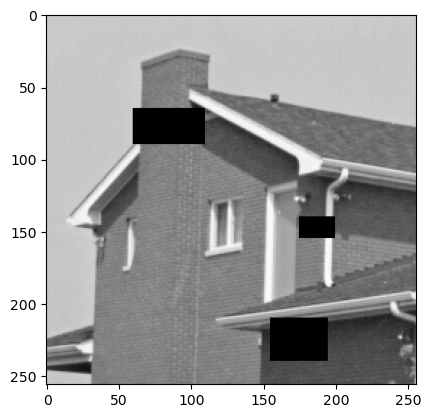

In [243]:
plt.imshow(mim, cmap='gray')

Status: 2
Iteration number: 168



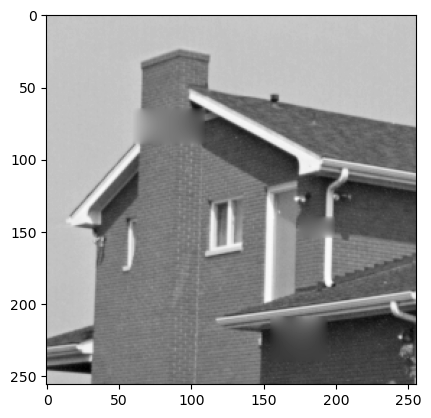

In [403]:
us_h, us_w = im.shape
A = construct_masking_operator(mask_h)
g = A @ im.flatten()
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

In [368]:
us_h, us_w = g_us.shape
A = construct_masking_operator(mask_us)
g = A @ g_us.flatten()
#plt.imshow(g.reshape((180, 64)), cmap='gray')
x_lsqr = solve_with_l1_reg(1e-2, A, g, us_h, us_w)

Status: 2
Iteration number: 17



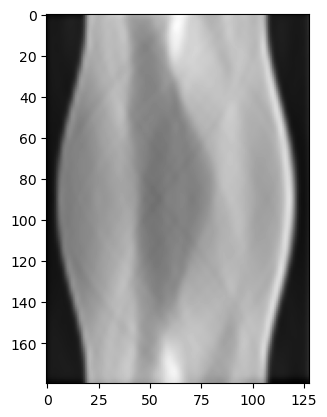

In [379]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=1.2)
plt.imshow(f_rec_lsqr, cmap='gray')

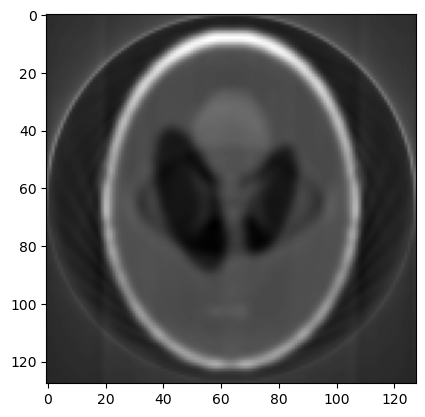

In [380]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
# gm = (A @ g.reshape((us_h * us_w,))).reshape((us_h, 32))
plt.imshow(rec, cmap='gray')

In [349]:
def construct_Radon_Operator(h, w, n_projs, n_angles, max_angle):

    def forward(v):
        im = v.reshape((h, w))
        angles = np.linspace(0, max_angle, n_angles, endpoint=False)
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(im, angles, n_projs)
        return g.reshape((n_projs * n_angles,))

    def backward(v):
        g = v.reshape((n_angles, n_projs))
        vol_geom = astra.create_vol_geom(h, w)
        angles = np.linspace(0, max_angle, n_angles, endpoint=False)
        proj_geom = astra.create_proj_geom('parallel', 1., n_projs, angles)
        projector_id = astra.create_projector('strip', proj_geom, vol_geom)
        _, back_projection = astra.create_backprojection(g, projector_id, returnData=True)
        return back_projection.reshape((h * w,))

    return scipy.sparse.linalg.LinearOperator((n_projs * n_angles, h * w), matvec=forward, rmatvec=backward)

def wavelet_decompose(data, wavelet_type, level):
    coeffs = pywt.wavedec2(data, wavelet_type, level=level)
    return coeffs

def wavelet_reconstruct(data, wavelet_type):
    f_rec = pywt.waverec2(data, wavelet_type)
    return f_rec

def extract_coeffs(coeffs):
    level = len(coeffs) - 1
    all_coeffs = []
    for i in range(1, level + 1):
        for c in coeffs[i]:
            all_coeffs.extend(c.flatten().tolist())
    all_coeffs = np.array(all_coeffs)
    non0_coeffs = all_coeffs[np.where(all_coeffs!=0)]
    abs_coeffs = np.abs(non0_coeffs)
    return non0_coeffs[np.argsort(abs_coeffs)]

def determine_abs_threshold(x, coeffs):
    non0_coeffs = extract_coeffs(coeffs)
    cn = non0_coeffs.shape[0]
    return np.abs(non0_coeffs[int(cn * x)])

def threshold_coeffs(coeffs, threshold, level, threshold_fucntion=None):
    new_coeffs = ()
    for c in coeffs[level]:
        if threshold_fucntion:
            new_coeffs += (threshold_fucntion(c, threshold),)
        else:
            new_coeffs += (pywt.threshold(c, threshold, mode='garrote', substitute=0),)
    coeffs[level] = new_coeffs

def threshold_specific_levels(coeffs, threshold, levels, threshold_fucntion=None):
    for level in levels:
        threshold_coeffs(coeffs, threshold, level, threshold_fucntion)

def visualize_coeffs(coeffs):
    A = coeffs[0]
    for coeff in coeffs[1:]:
        A = np.vstack((np.hstack((A, coeff[0])), np.hstack((coeff[1], coeff[2]))))
    plt.imshow(A, cmap='gray')
    return A

def soft_threshold(data, alpha):
    data_copy = data.copy()
    data_copy[data>=alpha] -= alpha
    data_copy[np.abs(data)<alpha] = 0
    data_copy[data<=-alpha] += alpha
    return data_copy

def ISTA(A, g, h, w, lam, alpha, it_num=100, wavelet_type='db4', level=5):
    mu = lam * alpha
    
    f_old = A.T @ g
    f_old = f_old - np.min(f_old)
    f_old = f_old / np.max(f_old)
    f_old = np.power(f_old, 3)
    for i in tqdm(range(it_num)):
        f_new = f_old - lam * A.T @ (A @ f_old - g)
        coeffs = wavelet_decompose(f_new.reshape((h, w)), wavelet_type, level)
        threshold_specific_levels(coeffs, mu, range(1, level + 1), soft_threshold)
        f_old = wavelet_reconstruct(coeffs, wavelet_type).reshape((h * w))
    
    return f_old.reshape((h, w))

In [361]:
R_op = construct_Radon_Operator(128, 128, 128, 180, np.pi)

In [362]:
u, s, vh = scipy.sparse.linalg.svds(R_op, k=1, which='LM')
lam = 1.5 / s.item() / s.item()
alpha = 0.5

In [363]:
f_rec = ISTA(R_op, f_rec_lsqr.flatten(), 128, 128, lam, alpha, it_num=1000, wavelet_type='db4', level=4)

100%|██████████| 1000/1000 [01:10<00:00, 14.13it/s]


l2 distance:  25.209188852571128


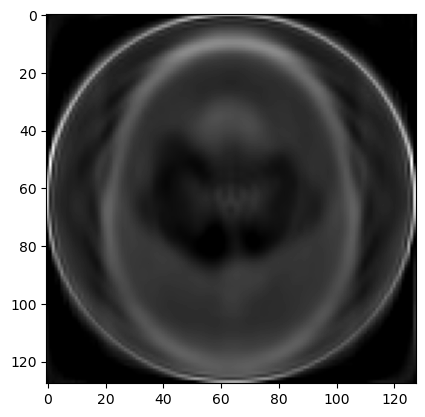

In [364]:
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

In [390]:
la_h, la_w = g_la.shape
A = construct_masking_operator(mask_la)
g = A @ g_la.flatten()
#plt.imshow(g.reshape((180, 32)), cmap='gray')
x_lsqr = solve_with_l1_reg(0.1, A, g, us_h, us_w)

Status: 2
Iteration number: 51



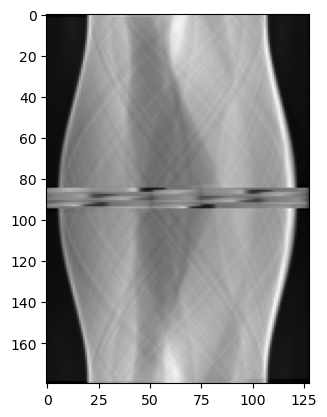

In [396]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
#f_rec_lsqr = scipy.ndimage.gaussian_filter(f_rec_lsqr, sigma=1.2)
plt.imshow(f_rec_lsqr, cmap='gray')

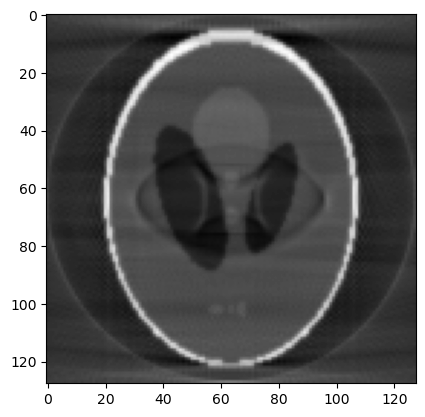

In [397]:
angles = np.linspace(0, np.pi, 180, endpoint=False)
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, angles, 128, 1)
rec_id, rec = astra.create_reconstruction('FBP', proj_id, f_rec_lsqr, returnData=True)
# gm = (A @ g.reshape((us_h * us_w,))).reshape((us_h, 32))
plt.imshow(rec, cmap='gray')

#### Use an anisotropic regulariser

In [412]:
def construct_gamma_delta(f):
    h, w = f.shape
    gx, gy = construct_delta_xy(h, w)
    
    ff = f.flatten()
    gfx = gx @ ff
    gfy = gy @ ff
    T = np.linalg.norm(np.sqrt(gfx * gfx + gfy * gfy)) / 1000
    gamma_d = np.exp(-np.sqrt(gfx * gfx + gfy * gfy) / T)
    gamma = scipy.sparse.diags(gamma_d)

    return np.sqrt(gamma) @ gx, np.sqrt(gamma) @ gy

In [409]:
def solve_with_af(alpha, A, g, f):
    gx, gy = construct_gamma_delta(f)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

In [290]:
gx, gy = construct_gamma_delta(f_true)
print(gx.shape, gy.shape)

(16384, 16384) (16384, 16384)


In [418]:
us_h, us_w = g_us.shape
A = construct_masking_operator(mask_us)
print(A.shape)
g = A @ g_us.flatten()
# plt.imshow(g.reshape((180, 32)), cmap='gray')
x_lsqr = solve_with_af(100, A, g, g_us_true)

(11520, 23040)


Status: 2
Iteration number: 1996



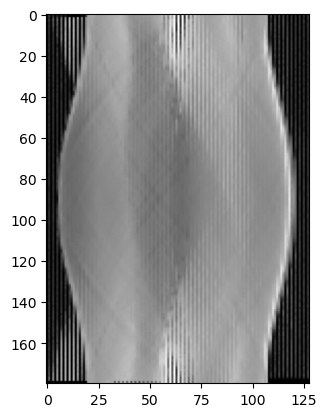

In [417]:
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')

(21760, 23040)
Status: 2
Iteration number: 51



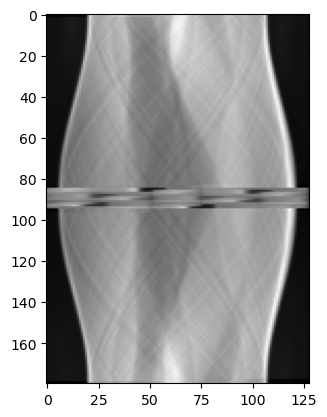

In [399]:
la_h, la_w = g_la.shape
A = construct_masking_operator(mask_la)
print(A.shape)
g = A @ g_la.flatten()
# plt.imshow(g.reshape((180, 32)), cmap='gray')
x_lsqr = solve_with_af(1e-1, A, g, g_us_true)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((la_h, la_w))
plt.imshow(f_rec_lsqr, cmap='gray')

Status: 2
Iteration number: 991



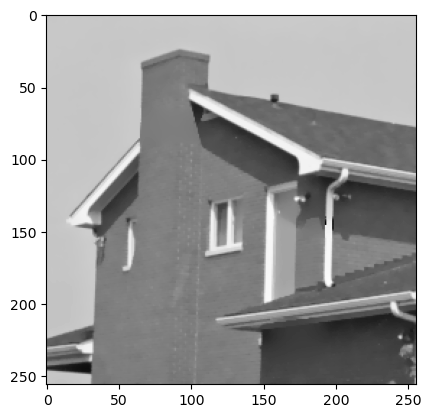

In [413]:
us_h, us_w = im.shape
A = construct_masking_operator(mask_h)
g = A @ im.flatten()
x_lsqr = solve_with_af(10, A, g, im)
print('Status: %d\nIteration number: %d\n' % (x_lsqr[1], x_lsqr[2]))
f_rec_lsqr = x_lsqr[0].reshape((us_h, us_w))
plt.imshow(f_rec_lsqr, cmap='gray')